In [1]:
import sys
import os

def get_FGCE_Directory():
    """Get the path of the 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness' directory."""
    current_dir = os.getcwd()
    target_dir = 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness'
    
    while os.path.basename(current_dir) != target_dir:
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
        
    return current_dir

def get_system_slash():
    """Get the system-specific directory separator."""
    return os.sep

FGCE_DIR = get_FGCE_Directory()
sys.path.append(FGCE_DIR)
sep = get_system_slash()
sys.path.append(FGCE_DIR + get_system_slash() + 'src')
from main import *

2024-08-12 18:36:33.872839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 18:36:33.872865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 18:36:33.873741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 18:36:33.878266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 18:36:34.407523: W tensorflow/compiler/tf2

# Decide Epsilon parameter

In [ ]:
from main import *
from utils import *
import math

dataset_results = {}

tp = 0.6
skip_bandwith_calculation=True
datasetName = 'Heloc'

data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns, min_max_scaler, data_df_copy, continuous_featues, one_hot_encode_features = load_dataset(datasetName=datasetName)
TEST_SIZE = 0.3

X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMNS]

data_np = data.to_numpy()
attr_col_mapping = {col: i for i, col in enumerate(data.columns)}

X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]
if isinstance(TARGET_COLUMNS, str):
    y = data_np[:, attr_col_mapping[TARGET_COLUMNS]]
else:
    y = data_np[:, [attr_col_mapping[col] for col in TARGET_COLUMNS]]

X_train, X_test, y_train, y_test = train_test_split(
    data[FEATURE_COLUMNS],
    data[TARGET_COLUMNS],
    test_size=TEST_SIZE,
    random_state=utils.random_seed,
    shuffle=True
)

index_mapping_test = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}
index_mapping_train = {new_index: original_index for new_index, original_index in enumerate(X_train.index)}

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

data_train = np.concatenate((X_train_np, y_train_np), axis=1)
data_test = np.concatenate((X_test_np, y_test_np), axis=1)

index_mapping = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}

if "LR_classifier_face_data.pk" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        print("Loading classifier from file ...")
        clf = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", "rb"))
else:
    clf = LogisticRegression(random_state=utils.random_seed)
    clf.fit(X_train, y_train)

    print("Training accuracy:", clf.score(X_train, y_train))
    print("Testing accuracy:", clf.score(X_test, y_test))

    if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}")

    pk.dump(clf, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", 'wb'))

FN, negative_points, positive_points, FP = utils.get_FN_Negatives_Positives(data_test, clf, tp, attr_col_mapping, FEATURE_COLUMNS, TARGET_COLUMNS, index_mapping)

results = {}
start=0.1
step=0.4

e = 0.1
if os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl"):
    distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "rb"))
else:
    kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
    kernel.fitKernel(X)
    fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
    feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=datasetName)
    dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
    distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(datasetName, data[FEATURE_COLUMNS], e, feasibility_constraints, None)

max_distances_in_the_dataset = math.ceil(np.max(distances))
print(f"Max distance in the dataset: {max_distances_in_the_dataset}")

for e in np.arange(start, max_distances_in_the_dataset, step):
    e = round(e, 1)
    print(f"Processing epsilon: {e}")
    if os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl") and os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl"):
        graph = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "rb"))
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        fgce.set_graph(graph)

        print("Loading distances from file ...")
        distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "rb"))

    else:
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=datasetName)

        start_time = time.time()
        dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
        distances, graph, densities = dng_obj.compute_pairwise_distances_and_graph_within_subgroups(datasetName, data[FEATURE_COLUMNS], e, feasibility_constraints, None)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Distances and graph initialization: ", execution_time, " seconds")

        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}")
        
        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities")

        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl"):
            pk.dump(distances, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances.pkl", "wb"))

        pk.dump(graph, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "wb"))
        pk.dump(densities, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}Densities_{e}.pkl", "wb"))

    try:
        print(f"Max possible distance considered in graph: {np.max([edge[2]['distance'] for edge in graph.edges(data=True)])}")
    except:
        print(f"Max possible distance considered in graph: {0}")

    strongly_connected_components = list(nx.strongly_connected_components(graph))
    weakly_connected_components = list(nx.weakly_connected_components(graph))

    connected_nodes = sum(1 for node, degree in graph.degree() if degree > 0)

    graph_density = nx.density(graph)

    d = {"strongly_connected_components": len(strongly_connected_components), "weakly_connected_components": len(weakly_connected_components),
        "Percentage_of_connected_nodes": (connected_nodes/len(X))*100, "Density": graph_density * 100}
    print(d,"\n")
    results[e] = d

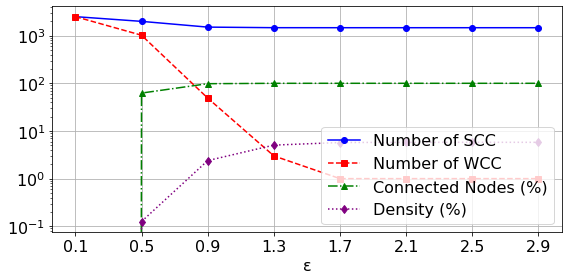

In [12]:
import matplotlib.pyplot as plt

epsilons = list(results.keys())
strongly_connected_components = [results[k]["strongly_connected_components"] for k in epsilons]
weakly_connected_components = [results[k]["weakly_connected_components"] for k in epsilons]
node_connectivity = [results[k]["Percentage_of_connected_nodes"] for k in epsilons]
edge_connectivity = [results[k]["Density"] for k in epsilons]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(epsilons, strongly_connected_components, marker='o', linestyle='-', color='b', label="Number of SCC")
ax.plot(epsilons, weakly_connected_components, marker='s', linestyle='--', color='r', label="Number of WCC")
ax.plot(epsilons, node_connectivity, marker='^', linestyle='-.', color='g', label="Connected Nodes (%)")
ax.plot(epsilons, edge_connectivity, marker='d', linestyle=':', color='purple', label="Density (%)")
ax.legend(loc='lower right', fontsize=16)
ax.set_xlabel("ε", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_yscale('log')
ax.set_xticks(epsilons)
plt.grid(True)
plt.tight_layout()
fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}figs{sep}{datasetName}_connectivity_plot.pdf")
plt.show()

# Testing for different Classifiers

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=1.7, tp=0.6, td=0.001, datasetName='Heloc', group_identifier='MaxDelqEver', group_identifier_value=5,
                            skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True,
                            max_d = 3, cost_function = "max_vector_distance", k=3,  k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=1.7, tp=0.6, td=0.001, datasetName='Heloc', group_identifier='MaxDelqEver', group_identifier_value=5,
                            skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True, classifier="xgb",
                            max_d = 3, cost_function = "max_vector_distance", k=3,  k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=1.7, tp=0.6, td=0.001, datasetName='Heloc', group_identifier='MaxDelqEver', group_identifier_value=5,
                            skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True, classifier="dnn",
                            max_d = 3, cost_function = "max_vector_distance", k=3,  k_selection_method="greedy_accross_all_ccs")[0]

# Graph Structure and aWWCs for selected e

In [15]:
import networkx as nx
import pickle
# results = main_cost_constrained_GCFEs(epsilon=1.7, tp=0.6, td=0.001, datasetName='Heloc', group_identifier='MaxDelqEver', group_identifier_value=5,
#                             skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True,
#                             max_d = 3, cost_function = "max_vector_distance", k=3,  k_selection_method="greedy_accross_all_ccs")[0]

with open(f"{FGCE_DIR}/tmp/Heloc/Graphs/Graph_1.4.pkl", "rb") as file:
    graph = pickle.load(file)

strongly_connected_components = list(nx.strongly_connected_components(graph))
weakly_connected_components = list(nx.weakly_connected_components(graph))

print("Strongly connected components:", len(strongly_connected_components))
print("Weakly connected components:", len(weakly_connected_components))

import json
with open(f"{FGCE_DIR}/tmp/Heloc/cost_constrained_GCFEs/results_Heloc_eps1.4_tp0.6_k_3_cost_function_max_vector_distance_d_3_kmethod_greedy_accross_all_ccs.json", "r") as file:
    results = json.load(file)

Strongly connected components: 1466
Weakly connected components: 1


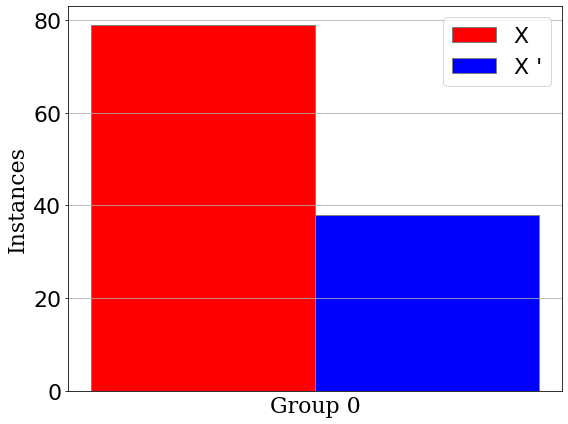

In [16]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['0.75_less']
aWCCs = set()
r0 = results['0.75_less']


for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 0', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Heloc{sep}figs{sep}ccs_positives_false_negatives_g0.pdf")

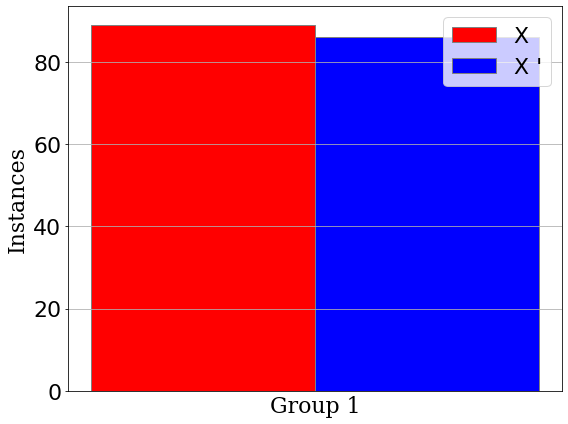

In [17]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['0.75_greater']
aWCCs = set()
r0 = results['0.75_greater']


for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 1', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Heloc{sep}figs{sep}ccs_positives_false_negatives_g1.pdf")
